In [ ]:
from qiskit_aer import Aer 
import numpy as np
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit.primitives import Sampler
from qiskit_optimization.applications import Maxcut
import networkx as nx

# Define the graph
G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (0, 2)])  # Adding edges
pos = nx.spring_layout(G)

# Convert the graph into a quadratic program using MaxCut
w = nx.adjacency_matrix(G).toarray()
maxcut = Maxcut(w)
quadratic_program = maxcut.to_quadratic_program()

# Define the backend and optimizer
#simulator = Aer.get_backend('statevector_simulator')  # Using the statevector simulator
#optimizer = COBYLA(maxiter=100)
optimizer = COBYLA()
##estimator=Estimator()
sampler = Sampler()

# Use QAOA with the Estimator primitive
qaoa = QAOA(sampler, optimizer, reps=2)  # Using 2 QAOA layers

#print(w)
# Get the operator and offset
#op, offset = quadratic_program.to_ising()



from qiskit.quantum_info import Pauli, SparsePauliOp


def get_operator(weight_matrix):
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 Separate the vertices into two set of the same size.
            2 Make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix: Adjacency matrix.
    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    coeffs = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(-0.5)
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(1.0)
            else:
                shift += 1

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift


op, offset = get_operator(w)
print(op)
print(offset)



#print(op)
qaoa_result = qaoa.compute_minimum_eigenvalue(op)

# Run the QAOA algorithm
qaoa_result = qaoa.compute_minimum_eigenvalue(op)
binary_string = qaoa_result.eigenstate
solution = np.array([int(bit) for bit in binary_string])

# Print the solution
print(f"Edges in the cut: {G.edges}")
print("max_cut = ", len(G.edges))


In [ ]:
#importing the networkx library
#from qiskit_aer import Aer
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
#from qiskit_aer import Aer 
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit.primitives import Sampler
from qiskit_optimization.applications import Maxcut
from qiskit.result import QuasiDistribution
from qiskit_algorithms.utils import algorithm_globals

n = 10
G= nx.erdos_renyi_graph(n,0.5)
#nx.draw(G, with_labels=True)


pos = nx.spring_layout(G)
for (u, v) in G.edges():
    G[u][v]['weight'] = random.uniform(1.0, 1.0)
colors = ["slateblue" for node in G.nodes()]

def f(G,colors,pos):
    nx.draw_networkx(G,node_color=colors,pos=pos)


w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i][j] = temp["weight"]
print(w)


def bitfield(n, L):
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part



def objective_value(x, w):
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)



quadratic_program = Maxcut(w).to_quadratic_program()
#print(maxcut)
#print(quadratic_program)

# Define the backend and optimizer
#simulator = Aer.get_backend('statevector_simulator')  # Using the statevector simulator
#optimizer = COBYLA(maxiter=100)
optimizer = COBYLA()
##estimator=Estimator()
sampler = Sampler()

# Use QAOA with the Estimator primitive
qaoa = QAOA(sampler, optimizer, reps=2)  # Using 2 QAOA layers
#print(w)
# Get the operator and offset


from qiskit.quantum_info import Pauli, SparsePauliOp


def get_operator(weight_matrix):
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 Separate the vertices into two set of the same size.
            2 Make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix: Adjacency matrix.
    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    coeffs = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(-0.5)
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(1.0)
            else:
                shift += 1

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift


op, offset = get_operator(w)
print(op)
print(offset)




def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """ 
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)



algorithm_globals.random_seed = 10598

optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=2)

result = qaoa.compute_minimum_eigenvalue(op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Objective value computed by QAOA is {objective_value(x, w)}")

"""
#op, offset = quadratic_program.to_ising()
#print(op)
# Run the QAOA algorithm
qaoa_result = qaoa.compute_minimum_eigenvalue(op)
binary_string = qaoa_result.eigenstate
solution = np.array([int(bit) for bit in binary_string])

print("sol = ",solution)
# Print the solution
cut_edges = [(i, j) for i, j in G.edges if solution[i] != solution[j]]
print(f"Edges in the cut: {cut_edges}")
print("max_cut by QAOA = ", len(cut_edges))
"""
sol = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    Cut_value = 0
    for i in range(n):
        for j in range(n):
            Cut_value += w[i][j]*x[i]*(1-x[j])
    if sol < Cut_value:
        sol = Cut_value
        xlist = x
    #print("case = " +str(x)+ " cut value = " +str(Cut_value))
colors = ["b" if xlist[i] == 0 else "r" for i in range(n)]
f(G,colors,pos)
print("classical max_cut solution = " +str(xlist)+ " cut value = " +str(sol))

In [ ]:
#importing the networkx library
#from qiskit_aer import Aer
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
#from qiskit_aer import Aer 
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit.primitives import Sampler
from qiskit_optimization.applications import Maxcut
from qiskit.result import QuasiDistribution
from qiskit_algorithms.utils import algorithm_globals


A,B,C=[],[],[]
for i in range(100):
    A.append(i+1)
    n = 10
    G= nx.erdos_renyi_graph(n,0.5)
    #nx.draw(G, with_labels=True)


    pos = nx.spring_layout(G)
    for (u, v) in G.edges():
        G[u][v]['weight'] = random.uniform(1.0, 1.0)
    colors = ["slateblue" for node in G.nodes()]

    def f(G,colors,pos):
        nx.draw_networkx(G,node_color=colors,pos=pos)


    w = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i,j,default=0)
            if temp != 0:
                w[i][j] = temp["weight"]
    #print(w)


    def bitfield(n, L):
        result = np.binary_repr(n, L)
        return [int(digit) for digit in result]  # [2:] to chop off the "0b" part



    def objective_value(x, w):
        X = np.outer(x, (1 - x))
        w_01 = np.where(w != 0, 1, 0)
        return np.sum(w_01 * X)



    quadratic_program = Maxcut(w).to_quadratic_program()
    #print(maxcut)
    #print(quadratic_program)

    # Define the backend and optimizer
    #simulator = Aer.get_backend('statevector_simulator')  # Using the statevector simulator
    #optimizer = COBYLA(maxiter=100)
    optimizer = COBYLA()
    ##estimator=Estimator()
    sampler = Sampler()

    # Use QAOA with the Estimator primitive
    qaoa = QAOA(sampler, optimizer, reps=2)  # Using 2 QAOA layers
    #print(w)
    # Get the operator and offset


    from qiskit.quantum_info import Pauli, SparsePauliOp


    def get_operator(weight_matrix):
        num_nodes = len(weight_matrix)
        pauli_list = []
        coeffs = []
        shift = 0

        for i in range(num_nodes):
            for j in range(i):
                if weight_matrix[i, j] != 0:
                    x_p = np.zeros(num_nodes, dtype=bool)
                    z_p = np.zeros(num_nodes, dtype=bool)
                    z_p[i] = True
                    z_p[j] = True
                    pauli_list.append(Pauli((z_p, x_p)))
                    coeffs.append(-0.5)
                    shift += 0.5

        for i in range(num_nodes):
            for j in range(num_nodes):
                if i != j:
                    x_p = np.zeros(num_nodes, dtype=bool)
                    z_p = np.zeros(num_nodes, dtype=bool)
                    z_p[i] = True
                    z_p[j] = True
                    pauli_list.append(Pauli((z_p, x_p)))
                    coeffs.append(1.0)
                else:
                    shift += 1

        return SparsePauliOp(pauli_list, coeffs=coeffs), shift


    op, offset = get_operator(w)
    #print(op)
    #print(offset)




    def sample_most_likely(state_vector):
        if isinstance(state_vector, QuasiDistribution):
            values = list(state_vector.values())
        else:
            values = state_vector
        n = int(np.log2(len(values)))
        k = np.argmax(np.abs(values))
        x = bitfield(k, n)
        x.reverse()
        return np.asarray(x)



    algorithm_globals.random_seed = 10598

    optimizer = COBYLA()
    qaoa = QAOA(sampler, optimizer, reps=2)

    result = qaoa.compute_minimum_eigenvalue(op)

    x = sample_most_likely(result.eigenstate)

    #print(x)
    #print(f"Objective value computed by QAOA is {objective_value(x, w)}")
    B.append(objective_value(x, w))

    """
    #op, offset = quadratic_program.to_ising()
    #print(op)
    # Run the QAOA algorithm
    qaoa_result = qaoa.compute_minimum_eigenvalue(op)
    binary_string = qaoa_result.eigenstate
    solution = np.array([int(bit) for bit in binary_string])

    print("sol = ",solution)
    # Print the solution
    cut_edges = [(i, j) for i, j in G.edges if solution[i] != solution[j]]
    print(f"Edges in the cut: {cut_edges}")
    print("max_cut by QAOA = ", len(cut_edges))
    """
    sol = 0
    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        Cut_value = 0
        for i in range(n):
            for j in range(n):
                Cut_value += w[i][j]*x[i]*(1-x[j])
        if sol < Cut_value:
            sol = Cut_value
            xlist = x
        #print("case = " +str(x)+ " cut value = " +str(Cut_value))
    C.append(int(sol))
    #colors = ["b" if xlist[i] == 0 else "r" for i in range(n)]
    #f(G,colors,pos)
    #print("classical max_cut solution = " +str(xlist)+ " cut value = " +str(sol))


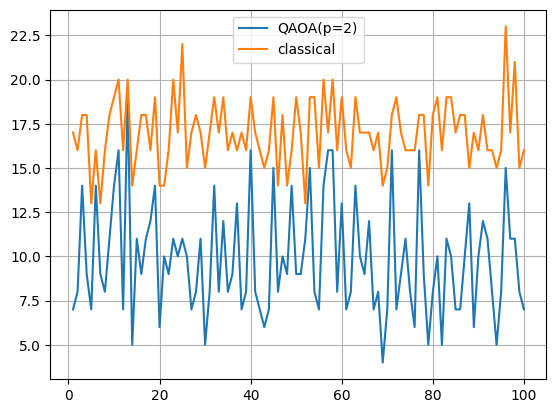

In [12]:
plt.plot(A,B,label='QAOA(p=2)')
plt.plot(A,C,label='classical')
plt.grid()
plt.legend()
plt.show()

## Complete QAOA code

[[0. 1. 1. 1. 1. 1. 1. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 0. 1.]
 [1. 1. 0. 1. 0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 1. 0. 1. 0. 0.]]
SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIZIIIIZ', 'IIIZIIIIIZ', 'ZIIIIIIIIZ', 'IIIIIIZIZI', 'IIIIIZIIZI', 'IZIIIIIIZI', 'IIIIIIZZII', 'IIIIZIIZII', 'IIIZIIIZII', 'IIZIIIIZII', 'ZIIIIIIZII', 'IIIIIZZIII', 'IIIIZIZIII', 'IIIZIIZIII', 'IIZIIIZIII', 'ZIIIIIZIII', 'IIIIZZIIII', 'IIIZIZIIII', 'IIZIIZIIII', 'IIIZZIIIII', 'IIZIZIIIII', 'ZIIIZIIIII', 'IZIZIIIIII', 'ZIZIIIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.

C:\Users\shubh\AppData\Local\Temp\ipykernel_4432\941199793.py:48: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()  # Samples the expectation values for all possible states


sorted points =  [(94, np.float64(0.0394457616863805)), (929, np.float64(0.0394457616863805)), (78, np.float64(0.018565119459474)), (945, np.float64(0.018565119459474)), (284, np.float64(0.0173628012382828)), (739, np.float64(0.0173628012382828)), (412, np.float64(0.0151304466523458)), (611, np.float64(0.0151304466523458)), (86, np.float64(0.0126065179253388)), (937, np.float64(0.0126065179253388)), (348, np.float64(0.0122843441020976)), (675, np.float64(0.0122843441020976)), (350, np.float64(0.0100076720383871)), (673, np.float64(0.0100076720383871)), (344, np.float64(0.0097298857378054)), (679, np.float64(0.0097298857378054)), (90, np.float64(0.0095029738820839)), (933, np.float64(0.0095029738820839)), (74, np.float64(0.0084091677966255)), (949, np.float64(0.0084091677966255)), (280, np.float64(0.006680829291451)), (743, np.float64(0.006680829291451)), (95, np.float64(0.0065398304322712)), (928, np.float64(0.0065398304322712)), (222, np.float64(0.0063084749750846)), (801, np.float64(

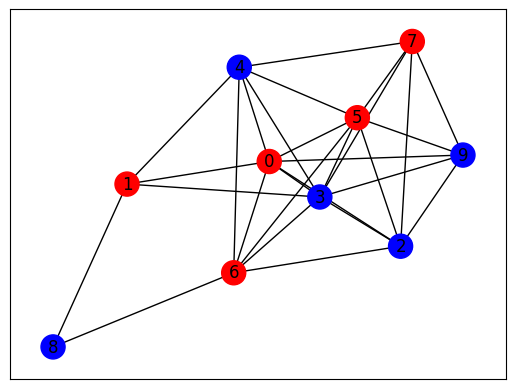

In [7]:
#importing the networkx library
import networkx as nx
import random
import numpy as np
from qiskit_algorithms.optimizers import COBYLA  # gradient free optimizer
from qiskit_algorithms.optimizers import L_BFGS_B  # gradient free optimizer
from qiskit_algorithms import QAOA
from qiskit.primitives import Sampler
from qiskit_optimization.applications import Maxcut


n = 10  # nodes
m = 2  # layes
G= nx.erdos_renyi_graph(n,0.5)
#nx.draw(G, with_labels=True)
#print(G.edges)

pos = nx.spring_layout(G)
for (u, v) in G.edges():
    G[u][v]['weight'] = random.uniform(1.0, 1.0)
colors = ["slateblue" for node in G.nodes()]

def f(G,colors,pos):
    nx.draw_networkx(G,node_color=colors,pos=pos)


w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i][j] = temp["weight"]
print(w)


quadratic_program = Maxcut(w).to_quadratic_program()
#print(maxcut)
#print(quadratic_program)

# Get the operator and offset for cost function
op, offset = quadratic_program.to_ising()
print(op)
#print('offset=',offset)

optimizer = COBYLA()  # Gradient Free optimizer
#optimizer = L_BFGS_B()  # Gradient based optimizer
#estimator=Estimator()
sampler = Sampler()  # Samples the expectation values for all possible states
# Use QAOA 
qaoa = QAOA(sampler, optimizer, reps=m)  # Using m QAOA layers
#print(w)

# Run the QAOA algorithm
qaoa_result = qaoa.compute_minimum_eigenvalue(op)
eigenstate = qaoa_result.eigenstate
#print("QAOA result = ",qaoa_result)
#print("Optimal value (Max-Cut):", qaoa_result.eigenvalue)


# sorting the eigen-states(in decimal) by their probabilities(in decreasing order)
sorted_points = sorted(eigenstate.items(), key=lambda x: x[1], reverse=True) 
print("sorted points = ",sorted_points)
optimal_state = sorted_points[0][0]  # Get the bitstring with the highest probability
print("Most likely state : ", optimal_state)
# Convert the bitstring into a binary array
solution = np.array([int(bit) for bit in reversed(list(bin(optimal_state)[2:].zfill(n)))])

# Print the solution
print("QAOA Optimal solution:", solution)
#print("Optimal value (Max-Cut):", qaoa_result.eigenvalue.real)


# Print the solution
cut_edges = [(i, j) for i, j in G.edges if solution[i] != solution[j]]
#print(f"Edges in the cut: {cut_edges}")
print("QAOA Maxcut solution = ", len(cut_edges))


# classical solution
sol = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    Cut_value = 0
    for i in range(n):
        for j in range(n):
            Cut_value += w[i][j]*x[i]*(1-x[j])
    if sol < Cut_value:
        sol = Cut_value
        xlist = x
colors = ["b" if xlist[i] == 0 else "r" for i in range(n)]
f(G,colors,pos)
print("classical solution = " ,xlist, " cut value = ",sol)